# Notes on Chapter 9 of *Hands-On Machine Learning with Scikit-Learn, Keras, & TensorFlow* by Aurélien Géron

In [1]:
import time

from matplotlib import pyplot as plt
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import silhouette_score, silhouette_samples

First we create some synthetic data with clusters similar to those shown in the book:

In [2]:
rng = np.random.default_rng(seed=42)

X_clusters = [
    (200, (-2.8, 2.8), 0.1),
    (200, (-2.8, 1.8), 0.1),
    (200, (-2.8, 1.3), 0.1),
    (200, (-1.5, 2.3), 0.3),
    (200, (0.2, 2.3), 0.4),
    ]

X = np.vstack([
    rng.normal(center, scale=scale, size=(count, len(center)))
    for count, center, scale in X_clusters
])
y = np.hstack([
    np.ones(dtype=int, shape=count) * i 
    for i, (count, center, scale) in enumerate(X_clusters)
])

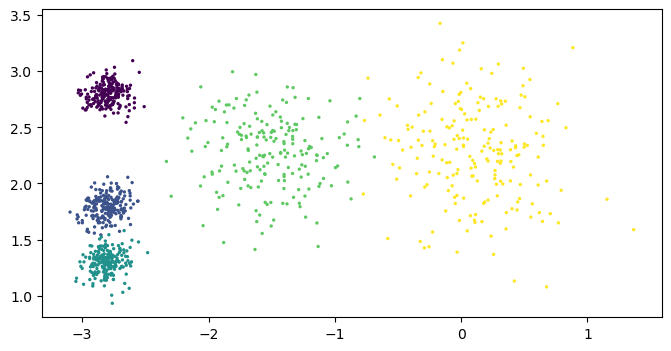

In [3]:
plt.figure(figsize=(8,4))
plt.scatter(X[:,0], X[:,1], s=2, c=y)

Next we try using K-means to cluster the data.

In [4]:
m = KMeans(n_clusters=5, random_state=42)
y_hat = m.fit_predict(X)

In [5]:
def KMeansPlot(m, X, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8,4))
        ax=fig.add_subplot()

    ax.scatter(X[:,0], X[:,1], s=2, c=y_hat)
    voronoi_plot_2d(Voronoi(m.cluster_centers_), show_points=False, show_vertices=False, ax=ax);
    ax.set_xlim((min(X[:,0]), max(X[:,0])))
    ax.set_ylim((min(X[:,1]), max(X[:,1])))
    ax.scatter(m.cluster_centers_[:,0], m.cluster_centers_[:,1], marker='x', color='black')

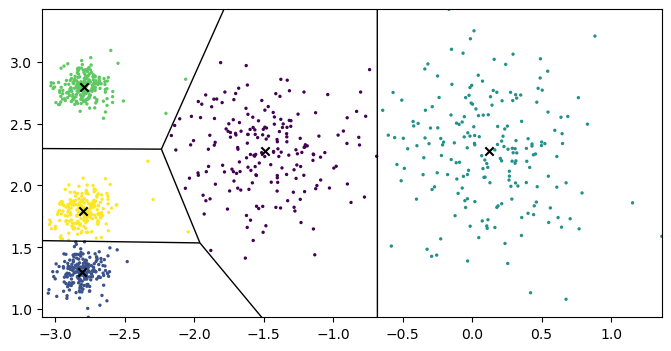

In [6]:
KMeansPlot(m, X)

For large datasets fitting the standard way may take some time

In [7]:
rng = np.random.default_rng(seed=42)
samples_per_cluster = 100000

X_large_clusters = [
    (samples_per_cluster, (-2.8, 2.8), 0.1),
    (samples_per_cluster, (-2.8, 1.8), 0.1),
    (samples_per_cluster, (-2.8, 1.3), 0.1),
    (samples_per_cluster, (-1.5, 2.3), 0.3),
    (samples_per_cluster, (0.2, 2.3), 0.4),
    ]

X_large = np.vstack([
    rng.normal(center, scale=scale, size=(count, len(center)))
    for count, center, scale in X_large_clusters
])
rng.shuffle(X_large)

In [8]:
fit_start_time = time.monotonic()
m = KMeans(n_clusters=5, random_state=42)
y_hat_large = m.fit_predict(X_large)
print(f"fit time: { time.monotonic() - fit_start_time:.2f} s") 

fit time: 1.99 s


A mini-batched version can be faster in these cases (and allow datasets larger than memory)

In [9]:
fit_start_time = time.monotonic()
m = MiniBatchKMeans(n_clusters=5, random_state=42)
y_hat_large = m.fit_predict(X_large)
print(f"fit time: { time.monotonic() - fit_start_time:.2f} s") 

fit time: 0.02 s


The quality of the fit of course depends on the choice of number of clusters:

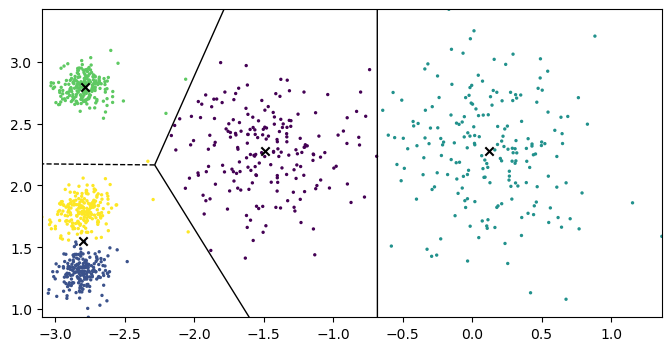

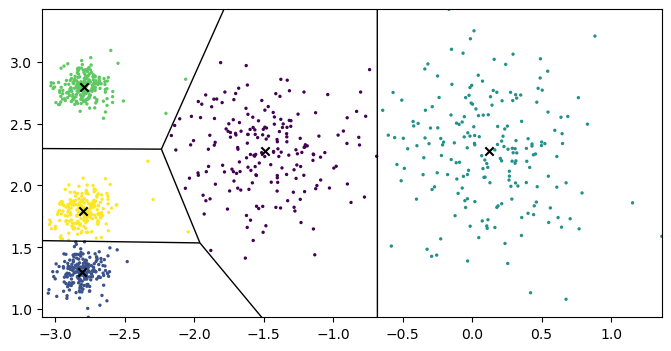

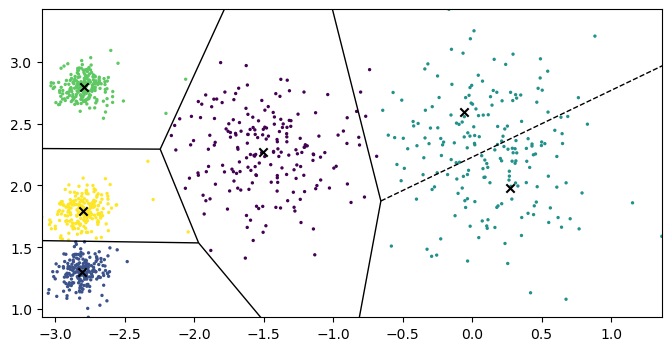

In [10]:
for k in range(4,7):
    KMeansPlot(KMeans(n_clusters=k, random_state=42).fit(X), X)

One way to choose the number of clusters is looking for an inflection point in the inertia (mean squared distance to the nearest centroid)

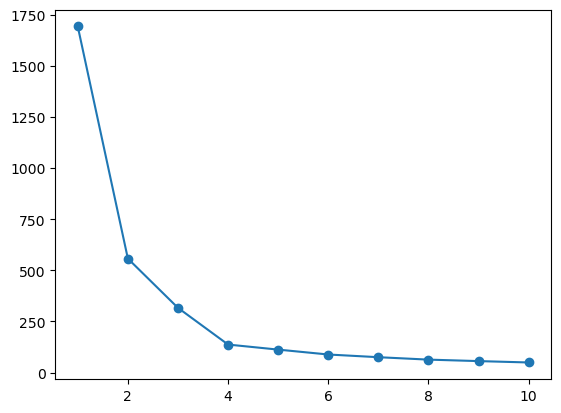

In [11]:
plt.plot(range(1,11), [KMeans(n_clusters=k, random_state=42).fit(X).inertia_ for k in range(1,11)], '-o')

Another (more expensive) option is to look at the silhouette coefficient $(b-a)/\max(a,b)$, where $a$ is the mean intracluster distance and $b$ is the mean distance to the nearest cluster instances. This score ranges from +1 for a perfect fit (close to all points in the cluster and far from other clusters) to -1 (likely mis-assignment of clusters).

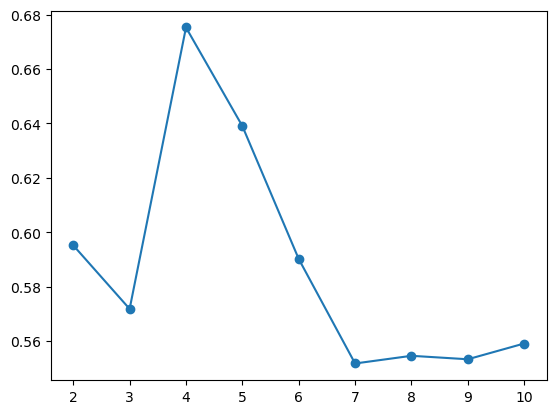

In [12]:
plt.plot(range(2,11), [silhouette_score(X, KMeans(n_clusters=k, random_state=42).fit(X).labels_) for k in range(2,11)], '-o')
